In [26]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'Handin4'))
from case_studies import f1, df1, Hf1, f4, df4, Hf4, f5, df5, Hf5, x_opt
import time
from collections import defaultdict


In [27]:
def wolfe_search(f, df, x, p, alpha0, c1, c2):
    """
    Implements the Wolfe line-search algorithm (Algorithm 8) which returns a
    step length fulfilling the strong Wolfe conditions.

    Arguments:
        f      : objective function f(x)
        df     : gradient function df(x)
        x      : current iterate
        p      : search direction
        alpha0 : initial upper bracket / step-length guess
        c1, c2 : Wolfe condition parameters (0 < c1 < c2 < 1)

    Returns:
        alpha    : step length satisfying the strong Wolfe conditions
        brackets : list of [l, u] brackets recorded at each iteration
    """
    # Scalar wrappers: g(a) = f(x + a*p),  g'(a) = ∇f(x+a*p)ᵀp
    def g(a):
        return f(x + a * p)

    def dg(a):
        return np.inner(df(x + a * p), p)

    l = 0
    u = alpha0
    brackets = [[l, u]]   # record initial bracket (iteration 1)

    # ── Phase 1: expansion ────────────────────────────────────────────
    while True:
        if g(u) > g(0) + c1 * u * dg(0) or g(u) > g(l):
            break
        if abs(dg(u)) < c2 * abs(dg(0)):
            return u, brackets
        if dg(u) > 0:
            break
        else:
            u = u * 2
            brackets.append([l, u])

    # ── Phase 2: bisection ────────────────────────────────────────────
    while True:
        brackets.append([l, u])
        a = (l + u) / 2
        if g(a) > g(0) + c1 * a * dg(0) or g(a) > g(l):
            u = a
        else:
            if abs(dg(a)) < c2 * abs(dg(0)):
                return a, brackets
            if dg(a) < 0:
                l = a
            else:
                u = a

In [28]:
def bfgs(f, df, Hf, x0, max_iter, epsilon, c1=1e-4, c2=0.9):
    """
    Implements the BFGS Quasi-Newton algorithm (Algorithm 9) using
    wolfe_search (Algorithm 8) for the line search.

    Arguments:
        f        : objective function f(x)
        df       : gradient function df(x)
        Hf       : Hessian function (unused, kept for uniform interface)
        x0       : initial iterate
        max_iter : maximum number of iterations
        epsilon  : stopping tolerance on gradient norm
        c1, c2   : Wolfe condition parameters (0 < c1 < c2 < 1)

    Returns:
        xs         : array of iterates [x_0, x_1, ..., x_k]
        grad_norms : array of gradient norms at each iterate
    """
    n = len(x0)
    H = np.eye(n)          # H_0 = I_n
    x = x0.copy()
    xs = [x.copy()]
    grad_norms = []

    for k in range(max_iter):
        grad = df(x)
        grad_norm = np.linalg.norm(grad)
        grad_norms.append(np.maximum(grad_norm, 1e-5 * epsilon))

        if grad_norm < epsilon:
            break

        # p_k = -H_k ∇f(x_k)
        p = -H @ grad

        # α_k via Wolfe line search
        alpha, _ = wolfe_search(f, df, x, p, 1.0, c1, c2)

        # x_{k+1} = x_k + α_k p_k
        x_new = x + alpha * p

        # s_k = x_{k+1} - x_k,  y_k = ∇f(x_{k+1}) - ∇f(x_k)
        s = alpha * p
        y = df(x_new) - grad

        # BFGS inverse-Hessian update
        sy = s @ y
        Hy = H @ y
        H = (H
             + ((sy + y @ Hy) / sy**2) * np.outer(s, s)
             - (np.outer(Hy, s) + np.outer(s, Hy)) / sy)

        x = x_new
        xs.append(x.copy())

    return np.array(xs), np.array(grad_norms)


In [29]:
def conjugate_gradients(Q, g, epsilon):
    """
    Conjugate Gradient method to find the minimum of f(x) = 1/2 x^T Q x + g^T x.
    Terminates when ||grad f(x)|| < epsilon.
    """
    x_k = np.zeros(g.shape[0])
    x_k_history = [x_k.copy()]

    grad_k = g.copy()
    p_k = -grad_k

    while True:
        Qp_k = Q @ p_k
        alpha_k = -(p_k @ grad_k) / (p_k @ Qp_k)
        x_k = x_k + alpha_k * p_k
        grad_k_next = Q @ x_k + g
        x_k_history.append(x_k.copy())

        if np.linalg.norm(grad_k_next) < epsilon:
            break

        beta_k = (grad_k_next @ Qp_k) / (p_k @ Qp_k)
        p_k = -grad_k_next + beta_k * p_k
        grad_k = grad_k_next

    return x_k, x_k_history


def newton_backtracking_eigenvalue(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Newton's Method with eigenvalue modification (Algorithm 4).
    Uses eigenvalue modification: H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ when H is not PD.
    """
    xs = []
    grad_norms = []
    i = 0
    b = 1
    x_current = x0.copy()

    def bt_LS(x, b, p_k):
        a = b
        while f(x + a * p_k) > f(x) + c1 * a * df(x).T @ p_k:
            a = rho * a
        return a

    def compute_newton_direction_eigenvalue(H, g):
        try:
            L = np.linalg.cholesky(H)
            y = np.linalg.solve(L, -g)
            p = np.linalg.solve(L.T, y)
            return p
        except np.linalg.LinAlgError:
            eigenvalues, eigenvectors = np.linalg.eigh(H)
            abs_inv_eigenvalues = 1.0 / np.abs(eigenvalues)
            temp = eigenvectors.T @ g
            temp = abs_inv_eigenvalues * temp
            p = -(eigenvectors @ temp)
            return p

    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5 * epsilon))
        if grad_norm < epsilon:
            break
        hess = Hf(x_current)
        p_k = compute_newton_direction_eigenvalue(hess, grad)
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k * p_k
        i += 1
        b = a_k / rho

    return np.array(xs), np.array(grad_norms)


def inexact_newton(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Inexact Newton's Algorithm (Algorithm 6).
    Uses conjugate gradients to approximately solve the Newton system,
    with a forcing sequence eta_k = min(0.5, sqrt(||grad f(x)||)).
    """
    xs = []
    grad_norms = []
    x_current = x0.copy()

    def bt_LS(x, p_k):
        a = 1.0
        while f(x + a * p_k) > f(x) + c1 * a * df(x) @ p_k:
            a = rho * a
        return a

    for k in range(max_iter):
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5 * epsilon))
        if grad_norm < epsilon:
            break
        eta_k = 0.5 * min(0.5, np.sqrt(grad_norm))
        epsilon_k = eta_k * grad_norm
        H = Hf(x_current)
        p_k, _ = conjugate_gradients(H, grad, epsilon_k)
        a_k = bt_LS(x_current, p_k)
        x_current = x_current + a_k * p_k

    return np.array(xs), np.array(grad_norms)


In [30]:
def generate_initial_points(x_optimal, n_points=100, variance=100, seed=42):
    """Generate initial points from N(x*, variance·I)"""
    np.random.seed(seed)
    dim = len(x_optimal)
    cov = variance * np.eye(dim)
    return np.random.multivariate_normal(x_optimal, cov, size=n_points)


def run_optimizer_with_tracking(optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon):
    """Run optimizer and track convergence metrics"""
    start_time = time.time()
    xs, grad_norms = optimizer(f, df, Hf, x0, max_iter, epsilon)
    elapsed_time = time.time() - start_time
    f_errors = np.array([f(x) - f_opt_val for x in xs])
    x_errors = np.array([np.linalg.norm(x - x_opt_val) for x in xs])
    return {
        'iterations': len(xs),
        'time': elapsed_time,
        'f_errors': f_errors,
        'x_errors': x_errors,
        'grad_norms': grad_norms
    }


def run_testing_protocol(function_suite, optimizers, n_initial_points=100, max_iter=1000, epsilon=1e-6):
    """Run complete testing protocol"""
    results = defaultdict(lambda: defaultdict(list))
    for func_name, f, df, Hf, dim in function_suite:
        x_opt_val = x_opt(func_name, dim)
        f_opt_val = f(x_opt_val)
        initial_points = generate_initial_points(x_opt_val, n_initial_points)
        for opt_name, optimizer in optimizers:
            for x0 in initial_points:
                try:
                    result = run_optimizer_with_tracking(
                        optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon
                    )
                    results[func_name][opt_name].append(result)
                except Exception:
                    continue
    return results


def aggregate_run_statistics(run_results):
    """Aggregate runs: median, 75th and 99th percentile over steps."""
    error_lists = [np.abs(r['f_errors']) + 1e-20 for r in run_results]
    lengths = [len(e) for e in error_lists]
    max_len = max(lengths)
    padded = np.array([
        np.pad(e, (0, max_len - len(e)), mode='edge') if len(e) < max_len else e
        for e in error_lists
    ])
    median_steps = np.percentile(padded, 50, axis=0)
    p75_steps    = np.percentile(padded, 75, axis=0)
    p99_steps    = np.percentile(padded, 99, axis=0)
    steps = np.arange(max_len)
    return {
        'steps': steps,
        'median_steps': median_steps,
        'p75_steps': p75_steps,
        'p99_steps': p99_steps,
    }


In [31]:
# --- function suite: f1, f4, f5 at dimension 200 ---
function_suite_all = [
    ("f1", f1, df1, Hf1, 200),
    ("f4", f4, df4, Hf4, 200),
    ("f5", f5, df5, Hf5, 200),
]

optimizers_test = [
    ("BFGS",            bfgs),
    ("Newton-BT",       newton_backtracking_eigenvalue),
    ("Inexact-Newton",  inexact_newton),
]

print("Running testing protocol on f1, f4, f5 with BFGS / Newton-BT / Inexact-Newton...")
results_test = run_testing_protocol(
    function_suite_all, optimizers_test,
    n_initial_points=10, max_iter=500, epsilon=1e-8
)
print("✓ Eta schedule comparison complete!")


Running testing protocol on f1, f4, f5 with BFGS / Newton-BT / Inexact-Newton...
✓ Eta schedule comparison complete!


/var/folders/0b/scq99ygn1h1ftyqsw6gnc08c0000gn/T/ipykernel_27971/3111949963.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


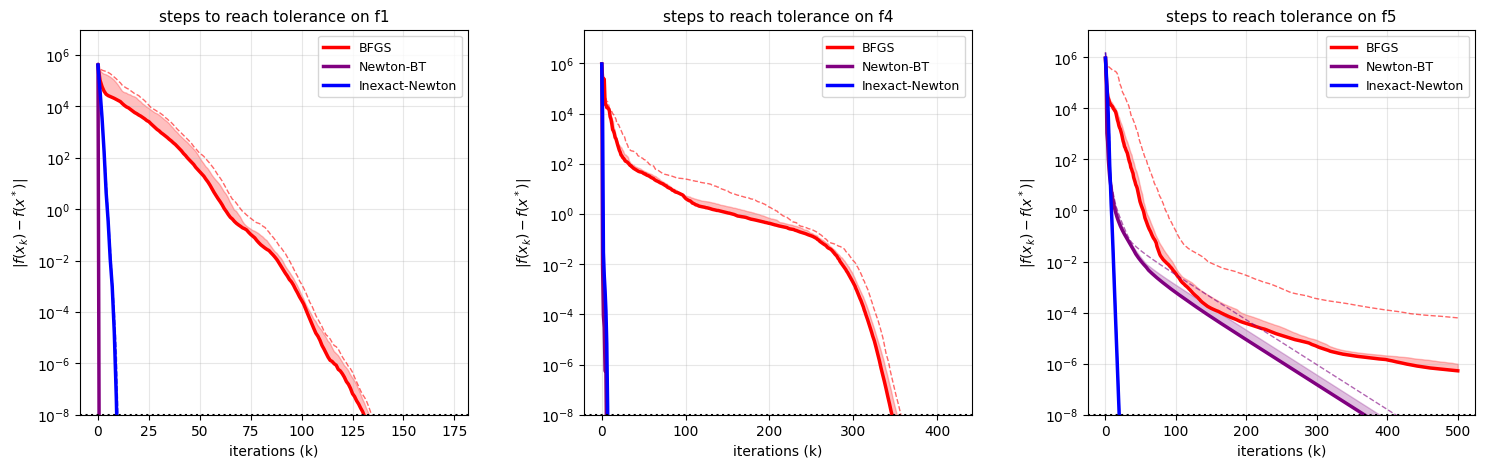


✓ Eta schedule comparison complete!


In [32]:
# Plot comparison: BFGS vs Newton-BT vs Inexact-Newton on f1, f4, f5 (steps only, 1x3)
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

colors = {
    'BFGS':           'red',
    'Newton-BT':      'purple',
    'Inexact-Newton': 'blue',
}
epsilon_plot = 1e-8

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

for idx, (func_name, _, _, _, _) in enumerate(function_suite_all):
    ax = axes[idx]

    for opt_name in ['BFGS', 'Newton-BT', 'Inexact-Newton']:
        run_results = results_test[func_name][opt_name]
        if not run_results:
            continue
        stats = aggregate_run_statistics(run_results)
        color = colors[opt_name]

        ax.semilogy(stats['steps'], stats['median_steps'],
                    color=color, linewidth=2.5, label=opt_name)
        ax.fill_between(stats['steps'],
                        stats['median_steps'], stats['p75_steps'],
                        color=color, alpha=0.25)
        ax.semilogy(stats['steps'], stats['p99_steps'],
                    color=color, linewidth=1, linestyle='--', alpha=0.6)

    ax.axhline(y=epsilon_plot, color='black', linestyle=':', linewidth=1.5)
    ax.set_ylim(bottom=epsilon_plot)
    ax.set_xlabel('iterations (k)', fontsize=10)
    ax.set_ylabel(r'$|f(x_k) - f(x^*)|$', fontsize=10)
    ax.set_title(f'steps to reach tolerance on {func_name}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('bfgs_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Eta schedule comparison complete!")
